## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
#print (objp)
#print (np.mgrid[0:9,0:6].T.reshape(-1,2))
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
#print (objp.shape)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #print(gray.shape)
    #print(gray.shape[::-1])
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(2000)
#cv2.destroyAllWindows()

## Undistort Functions

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undistimg = cv2.undistort(img, mtx, dist, None, mtx)
    return undistimg

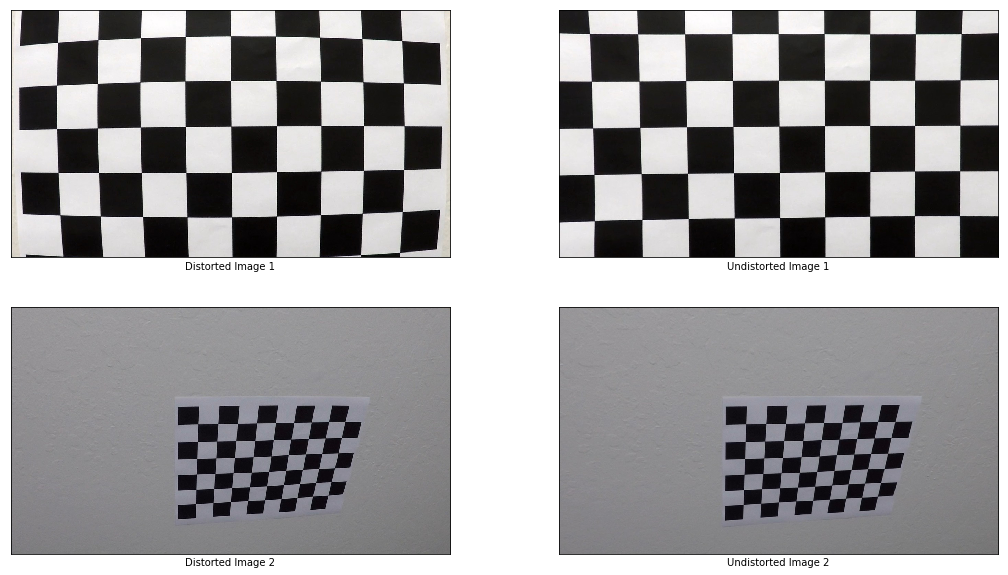

In [3]:
# Plotting Distorted vs Undistorted Calibration Images
%matplotlib inline
import math
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
UCALIMGS = []
CALIMGS = []

for fname in images:
    img = cv2.imread(fname)
    CALIMGS.append(img)
    undistort_img = cal_undistort(img, objpoints, imgpoints)
    UCALIMGS.append(undistort_img)

# Draw and display
fig, axes = plt.subplots(2, 2, figsize=(18,10))
for i, ax in enumerate(axes.flat):
    index = math.floor(i/2)
    if (i%2==0):
        ax.imshow(cv2.cvtColor(CALIMGS[index], cv2.COLOR_BGR2RGB))
        ax.set_xlabel("Distorted Image " + str(index+1))
    else:
        ax.imshow(cv2.cvtColor(UCALIMGS[index], cv2.COLOR_BGR2RGB))
        ax.set_xlabel("Undistorted Image " + str(index+1))
    ax.set_xticks([])
    ax.set_yticks([])

## Thresholding Functions

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Return this mask as your binary_output image
    return abs_sobel_thresh_1_channel(gray, orient, sobel_kernel, thresh)

def abs_sobel_thresh_1_channel(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if (orient == 'y'):
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return sxbinary    

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Perform sobel operation in both x and y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(gradmag)
    sxbinary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return this mask as your binary_output image
    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output    

def combine_GS_threshold(image, ksize=3, thresh=(0,255)):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(40, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

# Color (HLS) thresholding
# Use color thresholding on yellow line over light background where grayscale thresholding doesn't
# yield a good result
def hls_select(img, thresh=(0, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    # Return a binary image of threshold result
    return binary
    
# Combine thresholded images
def combine(img1, img2):
    # img1 and img2 are 1 channel images and have same shape 
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(img1)
    combined_binary[(img1 == 1) | (img2 == 1)] = 1
    return combined_binary

## Selected Thresholding Method
### Will use a combination of absolute sobel in x and HLS S channel thresholding for the final pipeline

In [5]:
# Thresholding Method
def custom_thresh(img, sobel_kernel=3, gs_thresh=(0,255), col_thresh=(0,255)):
    # Sobel x
    sobelx = abs_sobel_thresh(img, sobel_kernel=sobel_kernel, thresh=gs_thresh)
    # HLS thresholding
    hls_threshold = hls_select(img, thresh=col_thresh)

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sobelx), sobelx*255, hls_threshold*255))
     
    # Combine the two binary thresholds
    combined_binary = combine(sobelx, hls_threshold)
    return combined_binary, color_binary

## Plotting Test Images vs Undistorted Test Images

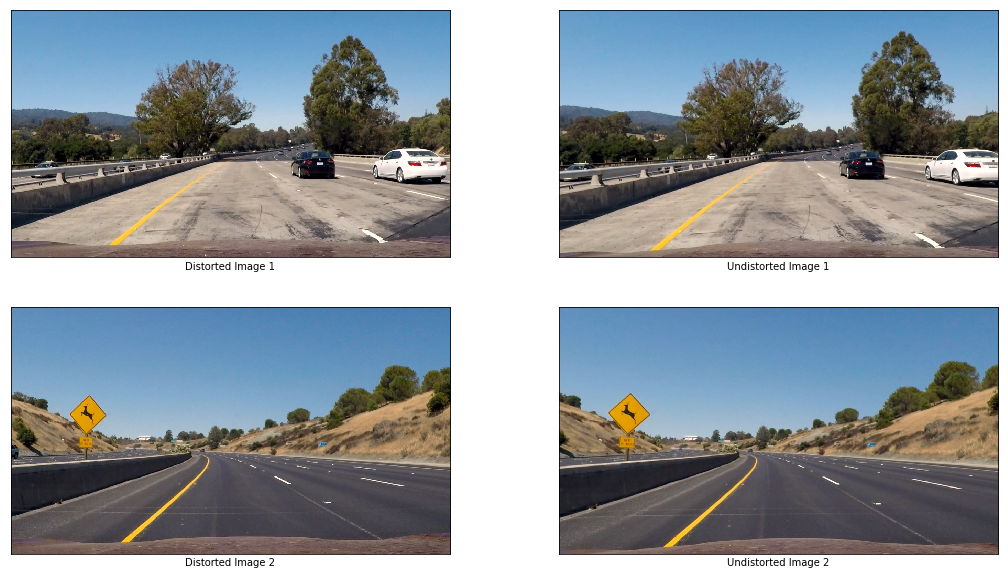

In [6]:
%matplotlib inline
import math
# Make a list of calibration images
images = glob.glob('test_images/test*.jpg')
UIMGS = []
IMGS = []
for fname in images:
    img = cv2.imread(fname)
    IMGS.append(img)
    undistort_img = cal_undistort(img, objpoints, imgpoints)
    UIMGS.append(undistort_img)

# Draw and display
fig, axes = plt.subplots(2, 2, figsize=(18,10))
for i, ax in enumerate(axes.flat):
    index = math.floor(i/2)
    if (i%2==0):
        ax.imshow(cv2.cvtColor(IMGS[index], cv2.COLOR_BGR2RGB))
        ax.set_xlabel("Distorted Image " + str(index+1))
    else:
        ax.imshow(cv2.cvtColor(UIMGS[index], cv2.COLOR_BGR2RGB))
        ax.set_xlabel("Undistorted Image " + str(index+1))
    ax.set_xticks([])
    ax.set_yticks([])

## Selecting which thresholding method works best for grayscale image
### Will use absolute sobel x gradient

[]

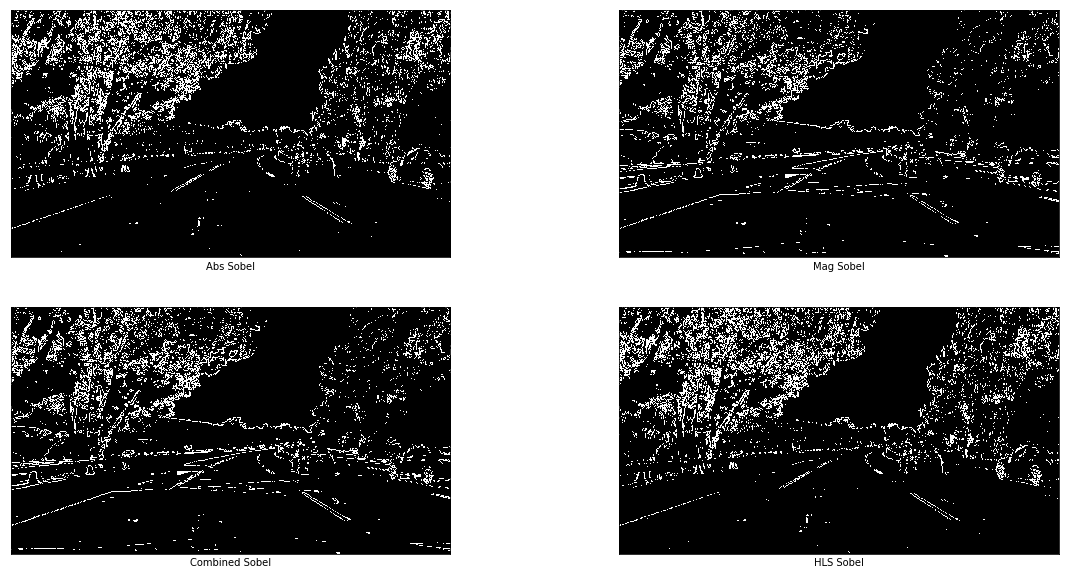

In [7]:
abs_sobel = abs_sobel_thresh(UIMGS[4], thresh=(20,100))
hsv = cv2.cvtColor(UIMGS[4], cv2.COLOR_RGB2HLS).astype(np.float)
l_channel = hsv[:,:,1]
s_channel = hsv[:,:,2]
hls_sobel = abs_sobel_thresh_1_channel(l_channel, thresh=(20, 100))
mag_sobel = mag_thresh(UIMGS[4], mag_thresh=(40,100))
combined_sobel = combine_GS_threshold(UIMGS[4])

# Draw and display
fig, axes = plt.subplots(2, 2, figsize=(20,10))
axes[0][0].imshow(abs_sobel, cmap='gray')
axes[0][0].set_xlabel("Abs Sobel")
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])
axes[0][1].imshow(mag_sobel, cmap='gray')
axes[0][1].set_xlabel("Mag Sobel")
axes[0][1].set_xticks([])
axes[0][1].set_yticks([])
axes[1][0].imshow(combined_sobel, cmap='gray')
axes[1][0].set_xlabel("Combined Sobel")
axes[1][0].set_xticks([])
axes[1][0].set_yticks([])
axes[1][1].imshow(hls_sobel, cmap='gray')
axes[1][1].set_xlabel("HLS Sobel")
axes[1][1].set_xticks([])
axes[1][1].set_yticks([])

## Visualize the result of the thresholded image 
### Using the combined sobel x and HLS S channel thresholding

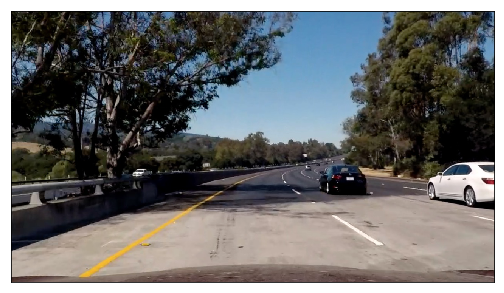

In [8]:
plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(UIMGS[4], cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

[]

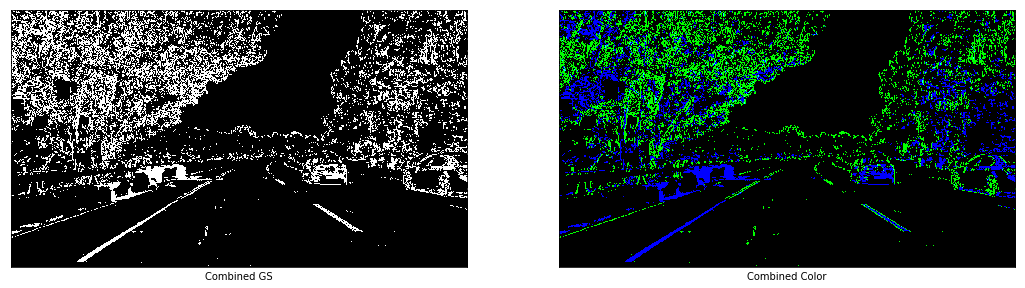

In [9]:
# Plotting thresholded images
img1, img2 = custom_thresh(UIMGS[4], gs_thresh=(20,100), col_thresh=(170,255))
fig, axes = plt.subplots(1, 2, figsize=(18,6))
axes[0].imshow(img1, cmap='gray')
axes[0].set_xlabel("Combined GS")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].imshow(img2)
axes[1].set_xlabel("Combined Color")
axes[1].set_xticks([])
axes[1].set_yticks([])

## Picking four corner points to be used in perspective transform
### Plot the points on test images

In [10]:
corners = [[1095,700], [710,460], [588,460], [244,700]]

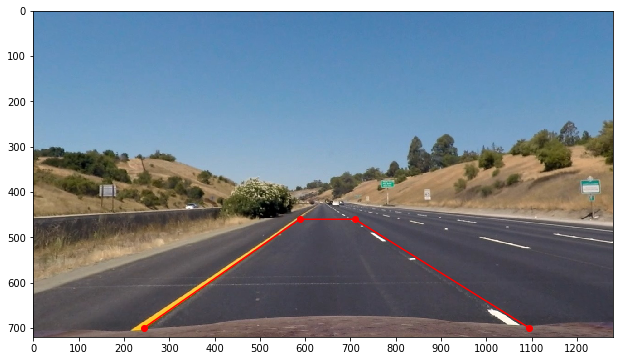

In [11]:
# Plotting straight line test images
# To find points for perspective transform
img_s1 = cv2.imread('test_images/straight_lines1.jpg')
u_img_s1 = cal_undistort(img_s1, objpoints, imgpoints)
plt.figure(figsize=(12,6))
xticks = np.arange(0,1300,100)
yticks = np.arange(0,750,100)
plt.imshow(cv2.cvtColor(u_img_s1, cv2.COLOR_BGR2RGB))
plt.xticks(xticks)
plt.yticks(yticks)
plt.plot(*zip(*corners), marker='o', color='r')
plt.show()

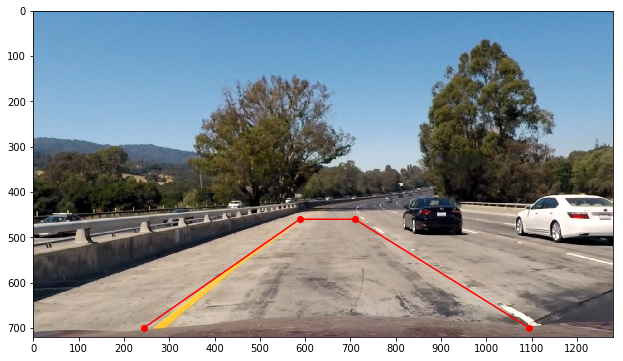

In [12]:
# Plotting straight line test images
# To find points for perspective transform
img_s1 = cv2.imread('test_images/test1.jpg')
u_img_s1 = cal_undistort(img_s1, objpoints, imgpoints)
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(u_img_s1, cv2.COLOR_BGR2RGB))
plt.xticks(xticks)
plt.yticks(yticks)
plt.plot(*zip(*corners), marker='o', color='r')
plt.show()

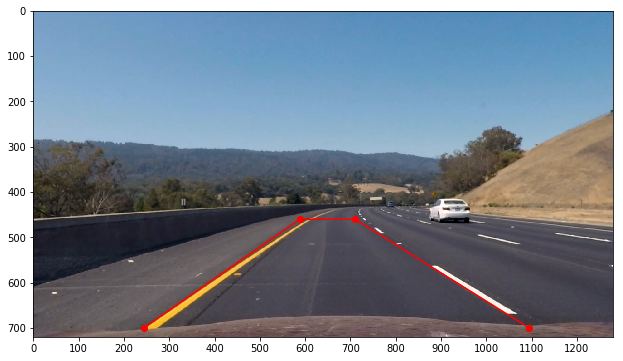

In [13]:
# Plotting straight line test images
# To find points for perspective transform
img_s1 = cv2.imread('test_images/test3.jpg')
u_img_s1 = cal_undistort(img_s1, objpoints, imgpoints)
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(u_img_s1, cv2.COLOR_BGR2RGB))
plt.xticks(xticks)
plt.yticks(yticks)
plt.plot(*zip(*corners), marker='o', color='r')
plt.show()

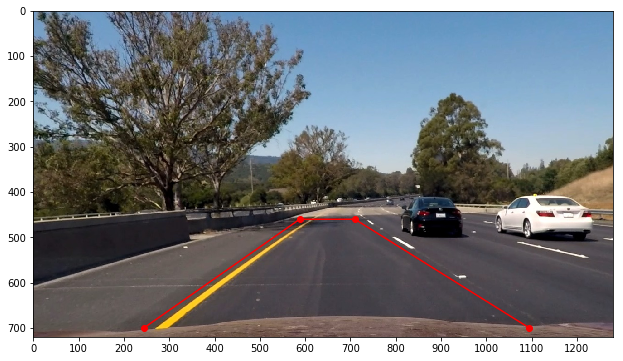

In [14]:
# Plotting straight line test images
# To find points for perspective transform
img_s1 = cv2.imread('test_images/test6.jpg')
u_img_s1 = cal_undistort(img_s1, objpoints, imgpoints)
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(u_img_s1, cv2.COLOR_BGR2RGB))
plt.xticks(xticks)
plt.yticks(yticks)
plt.plot(*zip(*corners), marker='o', color='r')
plt.show()

In [15]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def unwarp(img):
    # Img size
    img_size = (img.shape[1], img.shape[0])
    lastrow = img.shape[0]-1
    # Source pts
    # corners = [[1105,719], [645,420], [630,420], [205,719]]
    # src = np.float32([[685,450], [1105,lastrow], [205,lastrow], [598,450]])
    src = np.float32([corners[1], corners[0], corners[3], corners[2]])
    # print(src)
    # Destination pts
    #dst = np.float32([[1105,0], [1105,lastrow], [205,lastrow], [205,0]])
    dst = np.float32([[corners[0][0],0], [corners[0][0],lastrow-10], [corners[3][0],lastrow-10], [corners[3][0],0]])
    # print(dst)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    # Return the resulting image and matrix
    return warped, M, Minv

## Plotting perspective transformed test images

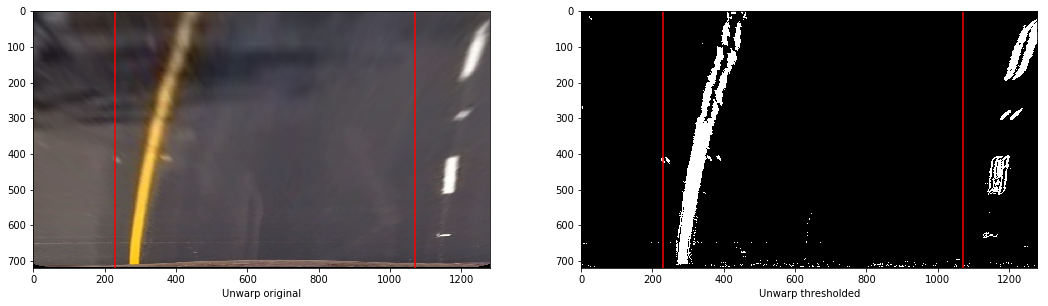

In [16]:
unwarp_img, M, Minv = unwarp(u_img_s1)
unwarp_img1, unwarp_img2 = custom_thresh(unwarp_img, gs_thresh=(20,100), col_thresh=(170,255))
figfig, axes = plt.subplots(1, 2, figsize=(18,6))
axes[0].imshow(cv2.cvtColor(unwarp_img, cv2.COLOR_BGR2RGB))
axes[0].set_xlabel("Unwarp original")
axes[0].plot([1070,1070],[719,0], color='r')
axes[0].plot([230,230],[719,0], color='r')
axes[1].imshow(unwarp_img1, cmap='gray')
axes[1].set_xlabel("Unwarp thresholded")
axes[1].plot([1070,1070],[719,0], color='r')
axes[1].plot([230,230],[719,0], color='r')
plt.show()

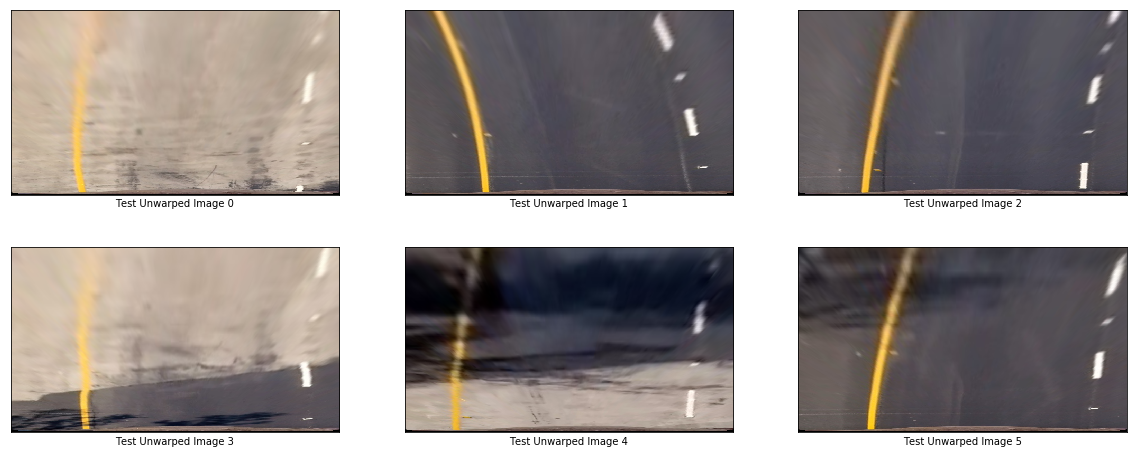

In [17]:
# Visualize the unwarp function
UUIMGS = []
for img in UIMGS:
    unwarp_img, M, Minv = unwarp(img)
    UUIMGS.append(unwarp_img)
  
# Draw and display
fig, axes = plt.subplots(2, 3, figsize=(20,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(UUIMGS[i], cv2.COLOR_BGR2RGB))
    ax.set_xlabel("Test Unwarped Image " + str(i))
    ax.set_xticks([])
    ax.set_yticks([])

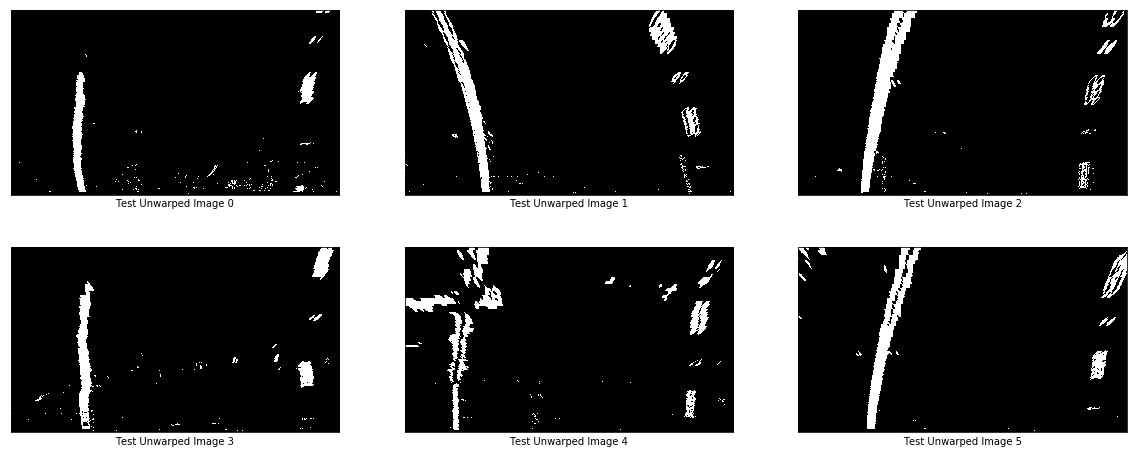

In [18]:
# Visualize the unwarp function
UUIMGS = []
for img in UIMGS:
    img1, img2 = custom_thresh(img, gs_thresh=(20,100), col_thresh=(170,255))
    unwarp_img, M, Minv = unwarp(img1)
    UUIMGS.append(unwarp_img)

# Draw and display
fig, axes = plt.subplots(2, 3, figsize=(20,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(UUIMGS[i], cmap='gray')
    ax.set_xlabel("Test Unwarped Image " + str(i))
    ax.set_xticks([])
    ax.set_yticks([])

## Method to find lanes on transformed image

In [19]:
def finding_lanes_sliding_windows(binary_warped, nwindows=9, margin=100, minpix=50, plot=False): 
    # nwindows: number of sliding windows
    # margin: The width of the windows +/- margin    
    # minpix: minimum number of pixels found to recenter window
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
  
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if (plot):
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    #print(left_fit)
    return left_fit, right_fit

In [20]:
def finding_lanes(binary_warped, left_fit, right_fit, margin=150, plot=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    #print (left_lane_inds.shape)
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if (plot):
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        #print(left_fitx)
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    #print (left_fit)
    return left_fit, right_fit

In [21]:
def measure_curvature(binary_warped, left_fit, right_fit):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image 
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    #print(left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m    
    return left_curverad, right_curverad

/home/osboxes/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(589.6646130930917, 1001.6332033989245)

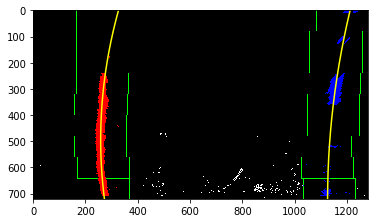

In [22]:
binary_warped = UUIMGS[0]
left_fit, right_fit = finding_lanes_sliding_windows(binary_warped, plot=True)
measure_curvature(binary_warped, left_fit, right_fit)

(731.72595245258015, 405.05841292942557)

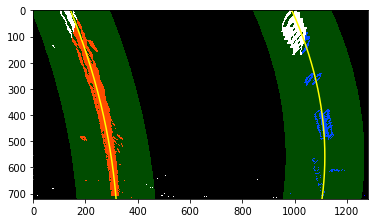

In [23]:
binary_warped = UUIMGS[1]
left_fit, right_fit = finding_lanes(binary_warped, left_fit, right_fit, plot=True)
#left_fit, right_fit, out_img = finding_lanes_sliding_windows(binary_warped, plot=True)
measure_curvature(binary_warped, left_fit, right_fit)

(7069.6415151235733, 847.78878180888148)

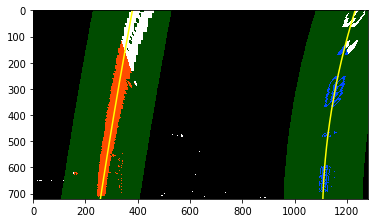

In [24]:
binary_warped = UUIMGS[2]
left_fit, right_fit = finding_lanes(binary_warped, left_fit, right_fit, plot=True)
measure_curvature(binary_warped, left_fit, right_fit)

(1609.3113014696182, 350.06335495877363)

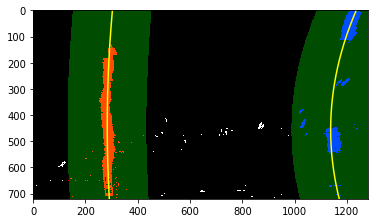

In [25]:
binary_warped = UUIMGS[3]
left_fit, right_fit = finding_lanes(binary_warped, left_fit, right_fit, plot=True)
measure_curvature(binary_warped, left_fit, right_fit)

(2768.5265396363407, 1322.2796614459473)

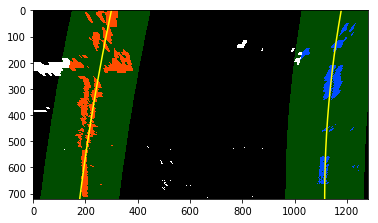

In [26]:
binary_warped = UUIMGS[4]
left_fit, right_fit = finding_lanes(binary_warped, left_fit, right_fit, plot=True)
measure_curvature(binary_warped, left_fit, right_fit)

(1812.5193238777886, 831.43159731331764)

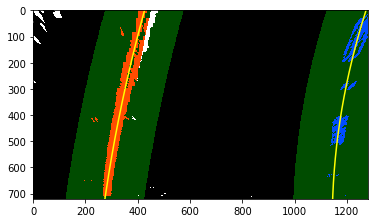

In [27]:
binary_warped = UUIMGS[5]
left_fit, right_fit = finding_lanes(binary_warped, left_fit, right_fit, plot=True)
measure_curvature(binary_warped, left_fit, right_fit)

## Method to draw/highlight lanes on the transformed image and transform the warped image back to the original image

In [28]:
def draw_lines_on_frame2(image, binary_warped, left_fitx, right_fitx, Minv):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

In [29]:
def draw_lines_on_frame(image, binary_warped, left_fit, right_fit, Minv):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return draw_lines_on_frame2(image, binary_warped, left_fitx, right_fitx, Minv)

/home/osboxes/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


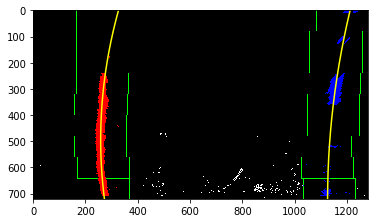

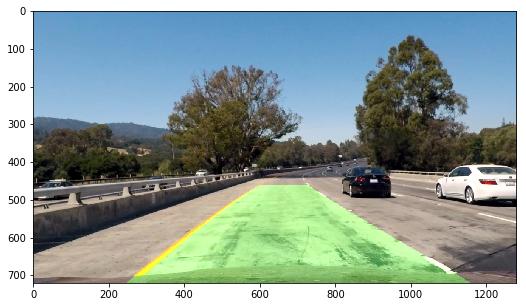

In [30]:
binary_warped = UUIMGS[0]
left_fit, right_fit = finding_lanes_sliding_windows(binary_warped, plot=True)

result = draw_lines_on_frame(UIMGS[0], binary_warped, left_fit, right_fit, Minv)
plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

## Building the pipeline

In [31]:
# Define a class to receive the characteristics of each line detection
from collections import deque
class Line():
    def __init__(self):
        # num iterations
        self.n = 10
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = deque([])
        # average x values of the fitted line over the last n iterations
        self.bestx = None
        self.current_xfit = None
        self.mean_bestx = None
        self.mean_currentx = None
        
        # polynomial coefficients over the last n iterations
        self.recent_fits = deque([])
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = np.array([0,0,0], dtype='float')    
        # polynomial coefficients for the most recent fit
        self.current_fit = np.array([0,0,0], dtype='float')
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
    
    def update_x_fit(self, xfit):
        if (len(self.recent_xfitted) == self.n):
            self.recent_xfitted.popleft()
        self.recent_xfitted.append(xfit)
        self.bestx = np.zeros_like(xfit)
        for x in self.recent_xfitted:
            self.bestx = self.bestx + x
        self.bestx = self.bestx/len(self.recent_xfitted)
        self.current_xfit = xfit
        self.mean_bestx = np.mean(self.bestx)
        self.mean_currentx = np.mean(self.current_xfit)
        
    def update_fit(self, fit):        
        if (len(self.recent_fits) == self.n):
            self.recent_fits.popleft()
        self.recent_fits.append(fit)
        self.best_fit = np.zeros_like(fit)
        for x in self.recent_fits:
            self.best_fit = self.best_fit + x
        self.best_fit = self.best_fit/len(self.recent_fits)
        self.diffs = fit - self.current_fit
        self.current_fit = fit
        ploty = np.linspace(0, 719, 720)
        fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        self.update_x_fit(fitx)

In [32]:
def get_transformed_image(img):
    # Distortion Correction
    uimg = cal_undistort(img, objpoints, imgpoints)
    # Thresholding
    uimg1, uimg2 = custom_thresh(uimg, gs_thresh=(20,100), col_thresh=(170,255))
    # Perspective Transform
    binary_warped, M, Minv = unwarp(uimg1)
    return binary_warped, Minv

In [33]:
L = Line()
L.n = 5
R = Line()
R.n = 5
LCUR = []
RCUR = []

def pipeline(img):
    left_fit = np.array([0,0,0])
    right_fit = np.array([0,0,0])
    
    # Get the perspective transformed image
    binary_warped, Minv = get_transformed_image(img)
    
    # Locate Lines
    if (np.any(L.current_fit) and np.any(R.current_fit)):
        left_fit, right_fit = finding_lanes(binary_warped, L.current_fit, R.current_fit)
    else:
        left_fit, right_fit = finding_lanes_sliding_windows(binary_warped)
        
    # Measure curvature
    lcur, rcur = measure_curvature(binary_warped, left_fit, right_fit)
    
    LCUR.append(lcur)
    RCUR.append(rcur)
    
    if (R.bestx is None or L.bestx is None):
        # Initial
        L.update_fit(left_fit)
        R.update_fit(right_fit)
        L.radius_of_curvature = lcur
        R.radius_of_curvature = rcur
        result = draw_lines_on_frame2(img, binary_warped, L.bestx, R.bestx, Minv)
        return result    
    
    # Sanity Checks
    ploty = np.linspace(0, 719, 720)
    fitL = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    fitR = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    currentWidth = np.mean(fitR - fitL)
    avgWidth = np.mean(R.bestx-L.bestx)
    diffWidth = abs(currentWidth-avgWidth)
    
    # If lane width is out of the ordinary or if line fit change sign (left turn to right turn) -> Reset
    laneWidthWrong = diffWidth > 0.15*avgWidth      
    signDiffers = (np.sign(L.current_fit[0]) != np.sign(left_fit[0])) or (np.sign(R.current_fit[0]) != np.sign(right_fit[0]))
    curvWrong = ((rcur<200) or (lcur<200))
    
    if (laneWidthWrong or signDiffers or curvWrong):
        # Reset
        left_fit, right_fit = finding_lanes_sliding_windows(binary_warped)
        lcur, rcur = measure_curvature(binary_warped, left_fit, right_fit)
        
        fitL = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        fitR = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        currentWidth = np.mean(fitR - fitL)
        avgWidth = np.mean(R.bestx-L.bestx)
        diffWidth = abs(currentWidth-avgWidth)
      
        laneWidthWrong = diffWidth > 0.15*avgWidth
        curvWrong = ((rcur<200) or (lcur<200))
        
        if not (laneWidthWrong or curvWrong):
            L.update_fit(left_fit)
            R.update_fit(right_fit)
            L.radius_of_curvature = lcur
            R.radius_of_curvature = rcur
    else:
        L.update_fit(left_fit)
        R.update_fit(right_fit)
        L.radius_of_curvature = lcur
        R.radius_of_curvature = rcur
    
    # Draw Line on Frame
    result = draw_lines_on_frame2(img, binary_warped, L.bestx, R.bestx, Minv)
    return result

/home/osboxes/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


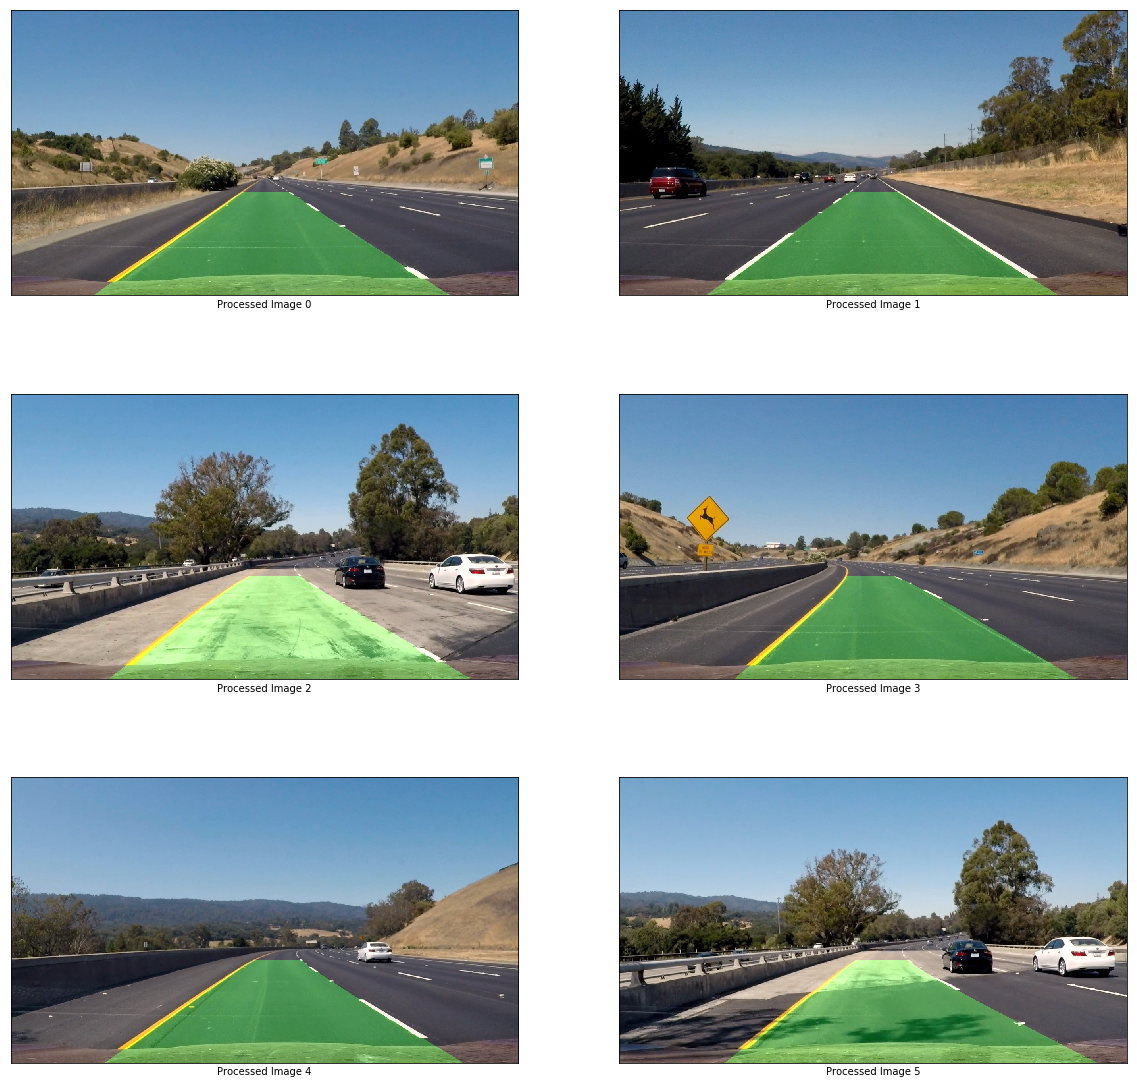

In [34]:
L = Line()
L.n = 1
R = Line()
R.n = 1
    
images = glob.glob('test_images/*.jpg')
PROCIMGS = []
for fname in images:
    img = cv2.imread(fname)
    proc_img = pipeline(img)
    PROCIMGS.append(proc_img)
    
# Draw and display
fig, axes = plt.subplots(3, 2, figsize=(20,20))
for i, ax in enumerate(axes.flat):
    ax.imshow(PROCIMGS[i])
    ax.imshow(cv2.cvtColor(PROCIMGS[i], cv2.COLOR_BGR2RGB))
    ax.set_xlabel("Processed Image " + str(i))
    ax.set_xticks([])
    ax.set_yticks([])

In [35]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
L = Line()
L.n = 5
R = Line()
R.n = 5
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = pipeline(image)
    return result

In [36]:
LCUR = []
RCUR = []
video_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [25:20<00:01,  1.37s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 25min 57s, sys: 4.96 s, total: 26min 2s
Wall time: 25min 23s


In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_output = 'project_video_out.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))